<font color='gray' size=6><b>MOVIE RECOMMENDER SYSTEM</b></font>

In [1]:
# Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate
import re

from sklearn.metrics.pairwise import cosine_similarity
import ipywidgets as widgets
from IPython.display import display

<font color='blue' size=5><b>Popularity-based recommender system at a genre level</b></font>

### Objective:
1. Create a popularity-based recommender system at a genre level. The user will input a
    genre (g), minimum rating threshold (t) for a movie, and no. of
    recommendations(N) for which it should be recommended top N movies which are
    most popular within that genre (g) ordered by ratings in descending order where each
    movie has at least (t) reviews.

In [2]:
# Load the dataset
movies = pd.read_csv("movies.csv")
ratings = pd.read_csv("ratings.csv")

In [3]:
# Display the dataset (5 rows)
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,16,4.0,1217897793
1,1,24,1.5,1217895807
2,1,32,4.0,1217896246
3,1,47,4.0,1217896556
4,1,50,4.0,1217896523


## ● Exploratory Data Analysis including:
    o Understanding of distribution of the features available
    o Finding unique users and movies
    o Average rating and Total movies at genre level.
    o Unique genres considered..

In [5]:
# Display all information about the features and Important data
print("@.... Information About the Movies Data :- ")
print("======================================================================================")
print("\nTotal Rows : ",movies.shape[0])
print("Total Columns : ",movies.shape[1])
print("\n********************************************")
print(movies.info())
print("\n********************************************")
print(movies.columns)

# Display all information about the features and Important data
print("\n\n\n@.... Information About the ratings Data :- ")
print("======================================================================================")
print("\nTotal Rows : ",ratings.shape[0])
print("Total Columns : ",ratings.shape[1])
print("\n********************************************")
print(ratings.info())
print("\n********************************************")
print(ratings.columns)

@.... Information About the Movies Data :- 

Total Rows :  10329
Total Columns :  3

********************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10329 entries, 0 to 10328
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  10329 non-null  int64 
 1   title    10329 non-null  object
 2   genres   10329 non-null  object
dtypes: int64(1), object(2)
memory usage: 242.2+ KB
None

********************************************
Index(['movieId', 'title', 'genres'], dtype='object')



@.... Information About the ratings Data :- 

Total Rows :  105339
Total Columns :  4

********************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105339 entries, 0 to 105338
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     105339 non-null  int64  
 1   movieId    105339 non-null  int64  
 2   rating

In [6]:
# Missing data analysis
print("Null Values Analysis(ratings Data) ;\n")
print(ratings.isnull().sum())
print("\nDuplicates : ",ratings.duplicated().sum())
print("\nDescribe Funtion :\n")
ratings.describe()

Null Values Analysis(ratings Data) ;

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

Duplicates :  0

Describe Funtion :



,userId,movieId,rating,timestamp
count,105339.000000,105339.000000,105339.000000,1.053390e+05
mean,364.924539,13381.312477,3.516850,1.130424e+09
std,197.486905,26170.456869,1.044872,1.802660e+08
min,1.000000,1.000000,0.500000,8.285650e+08
25%,192.000000,1073.000000,3.000000,9.711008e+08
50%,383.000000,2497.000000,3.500000,1.115154e+09
75%,557.000000,5991.000000,4.000000,1.275496e+09
max,668.000000,149532.000000,5.000000,1.452405e+09


#### From above the Average Rating is 3.5 and minimum and maximum rating is 3.5 & 5. The total users which provided rating as 668 for 149532 movies

In [7]:
# Missing data analysis
print("Null Values Analysis(movies Data) ;\n")
print(movies.isnull().sum())
print("\nDuplicates : ",movies.duplicated().sum())
print("\nDescribe Funtion :\n")
movies.describe()

Null Values Analysis(movies Data) ;

movieId    0
title      0
genres     0
dtype: int64

Duplicates :  0

Describe Funtion :



,movieId
count,10329.000000
mean,31924.282893
std,37734.741149
min,1.000000
25%,3240.000000
50%,7088.000000
75%,59900.000000
max,149532.000000


In [8]:
# Merge the dataset for combined analysis
movies_ratings = pd.merge(movies, ratings, on="movieId")
movies_ratings.head()

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,2,5.0,859046895
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0,1303501039
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,8,5.0,858610933
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,11,4.0,850815810
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,14,4.0,851766286


In [9]:
# Finding unique users and movies
Unique_user = movies_ratings["userId"].nunique()
Unique_movies = movies_ratings["movieId"].nunique()

print(f"Unique Users : {Unique_user}")
print(f"Unique Movies : {Unique_movies}")

Unique Users : 668
Unique Movies : 10325


In [10]:
# For example
Genre = "Comedy"
min_reviews = 100
top_recommdation = 10

In [11]:
# Split genres
movies_ratings["genres"] = movies_ratings["genres"].str.split('|')   # Converting each genre string into a list of genres.
movies_ratings = movies_ratings.explode("genres")  # It will now appear in multiple rows, one for each genre.
filter_movies_genres = movies_ratings[movies_ratings["genres"] == Genre]

In [12]:
#  Average rating and Total movies at genre level.
Average_rating_genre = movies_ratings.groupby("genres")["rating"].mean()
Total_movies_genre = movies_ratings.groupby("genres")["movieId"].nunique()

rating_movie_genre = pd.DataFrame({"Avg_rating":round(Average_rating_genre,1),"Total_movies":Total_movies_genre})
rating_movie_genre[1:]

,Avg_rating,Total_movies
genres,,
Action,3.5,1737
Adventure,3.5,1164
Animation,3.6,400
Children,3.4,540
Comedy,3.4,3513
Crime,3.6,1440
Documentary,3.6,415
Drama,3.7,5218
Fantasy,3.5,670


In [13]:
#Unique genres considered..
Unique_genres = movies_ratings["genres"].unique()
print(f"Unique Genres : {Unique_genres}")

Unique Genres : ['Adventure' 'Animation' 'Children' 'Comedy' 'Fantasy' 'Romance' 'Drama'
 'Action' 'Crime' 'Thriller' 'Horror' 'Mystery' 'Sci-Fi' 'IMAX' 'War'
 'Musical' 'Documentary' 'Western' 'Film-Noir' '(no genres listed)']


In [14]:
most_rated=movies_ratings['title'].value_counts().head(10)
most_rated

title
Pulp Fiction (1994)                 1300
Forrest Gump (1994)                 1244
Jurassic Park (1993)                1176
Toy Story (1995)                    1160
Lion King, The (1994)               1074
Aladdin (1992)                       955
Shrek (2001)                         948
True Lies (1994)                     920
Silence of the Lambs, The (1991)     870
Beauty and the Beast (1991)          858
Name: count, dtype: int64

### Data Visualizations

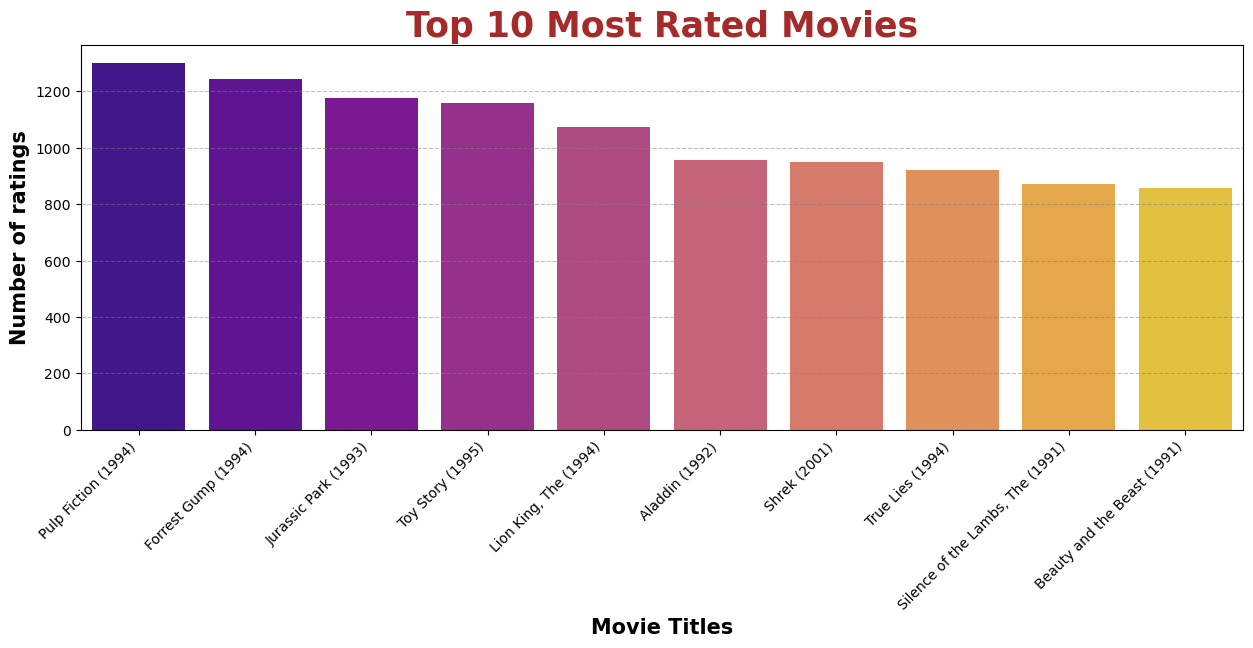

In [15]:
# Most Rated Movies

plt.figure(figsize=(15,5))
sns.barplot(x=most_rated.index,y=most_rated.values,palette='plasma')
plt.title("Top 10 Most Rated Movies", fontweight='bold',color='brown',size=25)
plt.xticks(rotation=45,ha='right')
plt.xlabel("Movie Titles",fontweight='bold',color='k',size=15)
plt.ylabel("Number of ratings",fontweight='bold',color='k',size=15)
plt.grid(axis='y',linestyle="--",color="gray",alpha=0.5)
plt.show()

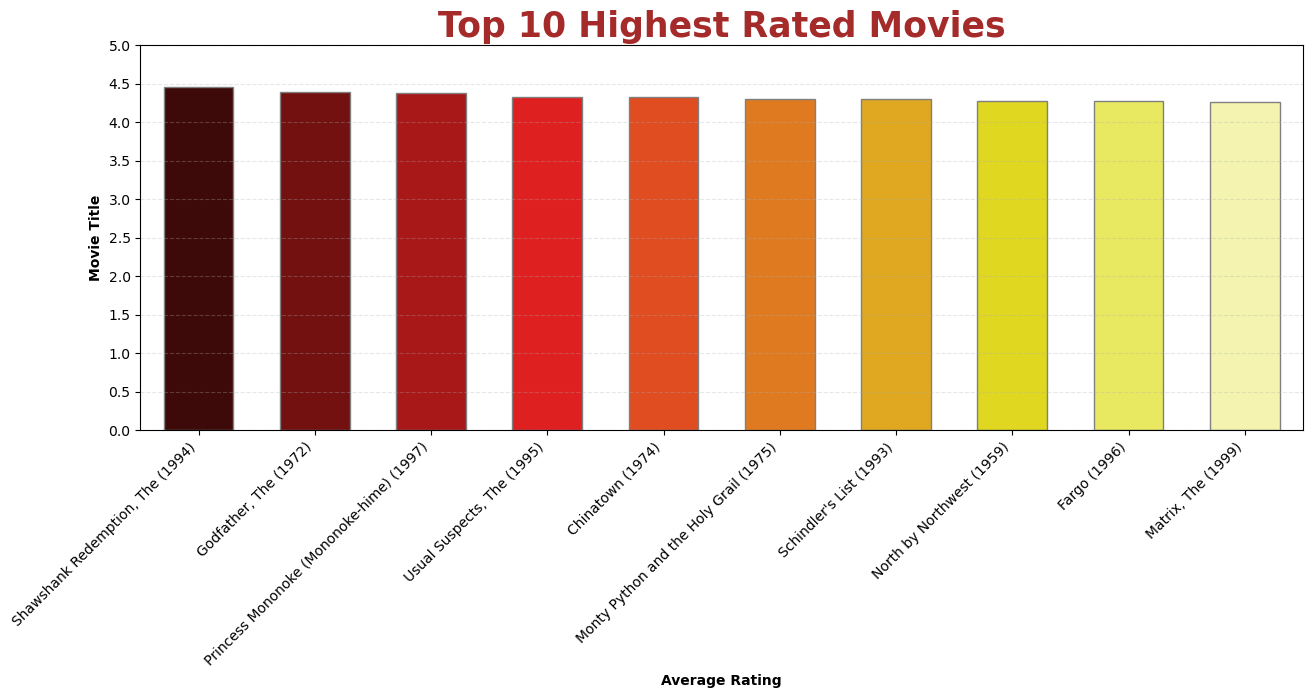

In [16]:
# Highest rated movies
avg_rating = movies_ratings.groupby('title')['rating'].mean()
rating_count = movies_ratings['title'].value_counts()
avg_rating_movie = avg_rating[rating_count > 200].sort_values(ascending=False).head(10)
plt.figure(figsize=(15,5))
sns.barplot(x=avg_rating_movie.index,y=avg_rating_movie.values,width=0.6,palette="hot",edgecolor='gray')
plt.ylabel("Movie Title",fontweight='bold',color='k',size=10)
plt.xlabel("Average Rating",fontweight='bold',color='k',size=10)
plt.xticks(rotation=45,ha='right')
plt.yticks(np.arange(0.0,5.1,0.5))
plt.title("Top 10 Highest Rated Movies", fontweight='bold',color='brown',size=25)
plt.grid(True,axis="y",linestyle="--",alpha=0.3)
plt.show()

In [17]:
movies_ratings.head()

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure,2,5.0,859046895
0,1,Toy Story (1995),Animation,2,5.0,859046895
0,1,Toy Story (1995),Children,2,5.0,859046895
0,1,Toy Story (1995),Comedy,2,5.0,859046895
0,1,Toy Story (1995),Fantasy,2,5.0,859046895


In [18]:
# Create a dataframe with the average rating and number of reviews for each movie.

Avg_ratings = filter_movies_genres.groupby("movieId").agg(avg_rating=("rating","mean"), top_reviews=("rating","count")).reset_index()
Avg_ratings = Avg_ratings.merge(movies[['movieId', 'title']], on='movieId')

In [19]:
Avg_ratings.head()

,movieId,avg_rating,top_reviews,title
0,1,3.907328,232,Toy Story (1995)
1,3,3.189655,58,Grumpier Old Men (1995)
2,4,2.818182,11,Waiting to Exhale (1995)
3,5,3.250000,62,Father of the Bride Part II (1995)
4,7,3.381818,55,Sabrina (1995)


In [20]:
Avg_ratings["avg_rating"] = round((Avg_ratings["avg_rating"]),1)

In [21]:
# Filter by minimum reviews threshold
filtered_ratings = Avg_ratings[Avg_ratings["top_reviews"]>= min_reviews]

# Sort ratings by avg ratings
Sort_ratings = filtered_ratings.sort_values(by= "avg_rating", ascending=False)

# Select top 10 movies
recommdation = Sort_ratings.head(top_recommdation)

In [22]:
recommdation.head()

,movieId,avg_rating,top_reviews,title
193,608,4.3,201,Fargo (1996)
326,1136,4.3,154,Monty Python and the Holy Grail (1975)
90,296,4.2,325,Pulp Fiction (1994)
337,1197,4.2,171,"Princess Bride, The (1987)"
1398,4973,4.1,119,"Amelie (Fabuleux destin d'Amélie Poulain, Le) ..."


In [23]:
Recommdation_user = recommdation.reset_index(drop=True)

# Display the recommdation
print(Recommdation_user[["title","avg_rating","top_reviews"]])

                                               title  avg_rating  top_reviews
0                                       Fargo (1996)         4.3          201
1             Monty Python and the Holy Grail (1975)         4.3          154
2                                Pulp Fiction (1994)         4.2          325
3                         Princess Bride, The (1987)         4.2          171
4  Amelie (Fabuleux destin d'Amélie Poulain, Le) ...         4.1          119
5                                Forrest Gump (1994)         4.1          311
6  Dr. Strangelove or: How I Learned to Stop Worr...         4.1          125
7                                      Clerks (1994)         4.0          101
8                        Being John Malkovich (1999)         4.0          124
9                           Big Lebowski, The (1998)         4.0          106


In [24]:
Recommdation_user.head(10)

,movieId,avg_rating,top_reviews,title
0,608,4.3,201,Fargo (1996)
1,1136,4.3,154,Monty Python and the Holy Grail (1975)
2,296,4.2,325,Pulp Fiction (1994)
3,1197,4.2,171,"Princess Bride, The (1987)"
4,4973,4.1,119,"Amelie (Fabuleux destin d'Amélie Poulain, Le) ..."
5,356,4.1,311,Forrest Gump (1994)
6,750,4.1,125,Dr. Strangelove or: How I Learned to Stop Worr...
7,223,4.0,101,Clerks (1994)
8,2997,4.0,124,Being John Malkovich (1999)
9,1732,4.0,106,"Big Lebowski, The (1998)"


In [25]:
from tabulate import tabulate

Table = Recommdation_user[["title","avg_rating","top_reviews"]].values.tolist()

for i,row in enumerate(Table):
    row.insert(0,i+1)

# Define Headers
headers = ["Sr.No","Movie Title","Average Movie Rating","Num Reviews"]

# Create table to display output
print(tabulate(Table, headers=headers, tablefmt='pretty'))

# 'plain', 'simple', 'grid', 'pipe', 'orgtbl', 'rst', 'mediawiki',
#'latex', 'latex_raw', 'latex_booktabs', 'latex_longtable' and tsv.


+-------+-----------------------------------------------------------------------------+----------------------+-------------+
| Sr.No |                                 Movie Title                                 | Average Movie Rating | Num Reviews |
+-------+-----------------------------------------------------------------------------+----------------------+-------------+
|   1   |                                Fargo (1996)                                 |         4.3          |     201     |
|   2   |                   Monty Python and the Holy Grail (1975)                    |         4.3          |     154     |
|   3   |                             Pulp Fiction (1994)                             |         4.2          |     325     |
|   4   |                         Princess Bride, The (1987)                          |         4.2          |     171     |
|   5   |            Amelie (Fabuleux destin d'Amélie Poulain, Le) (2001)             |         4.1          |     119     |


In [26]:
# create function to generate recommdation of Movies of user on basis of the genre(match the genre of users movies with 
# all movies and extrat top movies by rating)

def output(movies,ratings,Genre,min_reviews,top_recommdation):
    movies_ratings = pd.merge(movies, ratings, on="movieId")
    
    movies_ratings["genres"] = movies_ratings["genres"].str.split('|')   # Converting each genre string into a list of genres.
    movies_ratings = movies_ratings.explode("genres")  # It will now appear in multiple rows, one for each genre.
    filter_movies_genres = movies_ratings[movies_ratings["genres"] == Genre]
    
    Avg_ratings = filter_movies_genres.groupby("movieId").agg(avg_rating=("rating","mean"), top_reviews=("rating","count")).reset_index()
    Avg_ratings = Avg_ratings.merge(movies[['movieId', 'title']], on='movieId')
    Avg_ratings["avg_rating"] = round((Avg_ratings["avg_rating"]),1)
    
    # Filter by minimum reviews threshold
    filtered_ratings = Avg_ratings[Avg_ratings["top_reviews"]>= min_reviews]

    # Sort ratings by avg ratings
    Sort_ratings = filtered_ratings.sort_values(by= "avg_rating", ascending=False)

    # Select top 10 movies
    recommdation = Sort_ratings.head(top_recommdation)
    Recommdation_user = recommdation.reset_index(drop=True)
    
    Table = Recommdation_user[["title","avg_rating","top_reviews"]].values.tolist()

    for i,row in enumerate(Table):
        row.insert(0,i+1)

    # Define Headers
    headers = ["Sr.No","Movie Title","Average Movie Rating","Num Reviews"]

    # Create table to display output
    return print(tabulate(Table, headers=headers, tablefmt='pretty'))

In [27]:
# Create a function to take input from user and generate recommendation accordingly(using IPywidgets library)
def recommdation():
    print("*Movie Recommendation by Popularity")
    Genre_wid = widgets.Dropdown(
        options = sorted(movies["genres"].str.split("|").explode().unique()),
        description="Genre: ")
    min_reviews_wid = widgets.IntText(description="Minimum reviews threshold  : ")
    top_recommendation_wid = widgets.IntText(description="Num recommendations : ")
    
    inputs = widgets.VBox([Genre_wid, min_reviews_wid, top_recommendation_wid])
    display(inputs)
    
    # Adjust the layout to ensure the description labels are fully visible
    Genre_wid.style.description_width = 'initial'
    min_reviews_wid.style.description_width = 'initial'
    top_recommendation_wid.style.description_width = 'initial'
    
    def on_submit(change):
        Genre = Genre_wid.value
        min_reviews = min_reviews_wid.value
        top_recommdation = top_recommendation_wid.value
    
        output(movies,ratings,Genre,min_reviews,top_recommdation)
        
    button = widgets.Button(description="Get Recommendation")
    button.on_click(on_submit)
    display(button)

In [28]:
recommdation()

*Movie Recommendation by Popularity


Button(description='Get Recommendation', style=ButtonStyle())

+-------+------------------------------------------------------+----------------------+-------------+
| Sr.No |                     Movie Title                      | Average Movie Rating | Num Reviews |
+-------+------------------------------------------------------+----------------------+-------------+
|   1   |                     Fargo (1996)                     |         4.3          |     201     |
|   2   |        Monty Python and the Holy Grail (1975)        |         4.3          |     154     |
|   3   |                 Pulp Fiction (1994)                  |         4.2          |     325     |
|   4   |              Princess Bride, The (1987)              |         4.2          |     171     |
|   5   | Amelie (Fabuleux destin d'Amélie Poulain, Le) (2001) |         4.1          |     119     |
+-------+------------------------------------------------------+----------------------+-------------+


In [29]:
recommdation()

*Movie Recommendation by Popularity


Button(description='Get Recommendation', style=ButtonStyle())

+-------+----------------------------------------+----------------------+-------------+
| Sr.No |              Movie Title               | Average Movie Rating | Num Reviews |
+-------+----------------------------------------+----------------------+-------------+
|   1   |    Shawshank Redemption, The (1994)    |         4.5          |     308     |
|   2   |         Godfather, The (1972)          |         4.4          |     210     |
|   3   |     Godfather: Part II, The (1974)     |         4.3          |     140     |
|   4   |           Goodfellas (1990)            |         4.3          |     135     |
|   5   | One Flew Over the Cuckoo's Nest (1975) |         4.3          |     143     |
|   6   |              Fargo (1996)              |         4.3          |     201     |
|   7   |        Schindler's List (1993)         |         4.3          |     248     |
+-------+----------------------------------------+----------------------+-------------+


In [30]:
recommdation()

*Movie Recommendation by Popularity


Button(description='Get Recommendation', style=ButtonStyle())

+-------+----------------------------------+----------------------+-------------+
| Sr.No |           Movie Title            | Average Movie Rating | Num Reviews |
+-------+----------------------------------+----------------------+-------------+
|   1   | Silence of the Lambs, The (1991) |         4.2          |     290     |
+-------+----------------------------------+----------------------+-------------+


In [31]:
recommdation()

*Movie Recommendation by Popularity


Button(description='Get Recommendation', style=ButtonStyle())

+-------+--------------------------------------------------------------------------------+----------------------+-------------+
| Sr.No |                                  Movie Title                                   | Average Movie Rating | Num Reviews |
+-------+--------------------------------------------------------------------------------+----------------------+-------------+
|   1   |                     Monty Python and the Holy Grail (1975)                     |         4.3          |     154     |
|   2   |                   Star Wars: Episode IV - A New Hope (1977)                    |         4.2          |     273     |
|   3   | Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981) |         4.2          |     224     |
+-------+--------------------------------------------------------------------------------+----------------------+-------------+


<font color='blue' size=5><b>Content-based recommender system</b></font>

### Objective
2. Create a content-based recommender system that recommends top N movies based on
    similar movie(m) genres.

In [32]:
# Preprocess
movie_genre_matrix = movies.copy()
movie_genre_matrix["genres"] = movie_genre_matrix["genres"].str.split('|')   # Converting each genre string into a list of genres.
movie_genre_matrix = movie_genre_matrix.explode("genres")
movie_genre_matrix["value"] = 1
movie_genres_matrix = movie_genre_matrix.pivot_table(index='movieId', columns='genres', values='value', fill_value=0)
movie_genres_matrix.head()


genres,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieId,,,,,,,,,,,,,,,,,,,,
1,0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0
5,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [33]:
def content_recommaded(movie_name, top_n=10):
    # finds the movieId of the first movie
    movie_id = movies[movies['title'].str.contains(movie_name)].iloc[0]['movieId']
    # retrieves the vector representation (features/genres) of the movie corresponding to movie_id and reshapes it into a 2D array suitable for further processing
    movie_vector = movie_genres_matrix.loc[movie_id].values.reshape(1, -1)
    cosine_sim = cosine_similarity(movie_genres_matrix, movie_vector).flatten()
    # finds the indices of the top top_n most similar movies to the target movie, sorted by similarity in descending order.
    similar_movies_indices = cosine_sim.argsort()[-top_n-1:-1][::-1]
    similar_movies = movies.iloc[similar_movies_indices]
    return similar_movies[['title']]

#recommended_movies = content_recommaded("Toy Story", top_n=10)
#print(recommended_movies)

                                                  title
7382                             Shrek the Third (2007)
9215  Asterix and the Vikings (Astérix et les Viking...
1815                                        Antz (1998)
3166                   Emperor's New Groove, The (2000)
6997                                   Wild, The (2006)
2496                                 Toy Story 2 (1999)
9732                                       Turbo (2013)
3811                              Monsters, Inc. (2001)
6617  DuckTales: The Movie - Treasure of the Lost La...
2967     Adventures of Rocky and Bullwinkle, The (2000)


In [34]:
def Top_content_recommdation():
    print("*Movie Recommendation (Using Content)")
    movie_title_wid = widgets.Dropdown(options = sorted(movies["title"].unique()),description="Movie title get : ")
    movie_name_wid = widgets.Text(description="Enter Movie title : ")
    top_n_wid = widgets.IntText(description="Num Recommdation : ")
    
    inputs = widgets.VBox([movie_title_wid,movie_name_wid,top_n_wid])
    display(inputs)
    
    movie_title_wid.style.description_width = 'initial'
    movie_name_wid.style.description_width = 'initial'
    top_n_wid.style.description_width = 'initial'
    
    def on_submit(change):
        movie_name = movie_name_wid.value
        top_n = top_n_wid.value
        
        # Generate output title
        print(f"Top {top_n} Movie Recommendations for {movie_name}:")
    
        recommdation = content_recommaded(movie_name, top_n)
        recommdation.reset_index(drop=True, inplace=True)
        Table = recommdation[["title"]].values.tolist()
        for i,row in enumerate(Table):
            row.insert(0,i+1)
        # Define Headers
        headers = ["Sr.No","Movie Title"]
        print(tabulate(Table, headers=headers, tablefmt='pretty'))
    button =  widgets.Button(description = "Get Recommendation")
    button.on_click(on_submit)
    display(button)

In [35]:
Top_content_recommdation()

*Movie Recommendation (Using Content)


Button(description='Get Recommendation', style=ButtonStyle())

Top 5 Movie Recommendations for 3 Idiots:
+-------+------------------------+
| Sr.No |      Movie Title       |
+-------+------------------------+
|   1   |    Spanglish (2004)    |
|   2   |  My Sassy Girl (2008)  |
|   3   | Ugly Truth, The (2009) |
|   4   |  Julie & Julia (2009)  |
|   5   | Hobson's Choice (1954) |
+-------+------------------------+


In [36]:
Top_content_recommdation()

*Movie Recommendation (Using Content)


Button(description='Get Recommendation', style=ButtonStyle())

Top 2 Movie Recommendations for Rising Sun:
+-------+--------------------------+
| Sr.No |       Movie Title        |
+-------+--------------------------+
|   1   | Gleaming the Cube (1989) |
|   2   |      Oldboy (2013)       |
+-------+--------------------------+


<font color='blue' size=5><b>Collaborative based recommender system</b></font>

### Objective
3. Create a collaborative based recommender system which recommends top N movies
    based on “K” similar users for a target user “u”

In [37]:
user_movie_matrix = ratings.pivot(index="userId", columns="movieId", values="rating").fillna(0)
user_movie_matrix.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,144482,144656,144976,146344,146656,146684,146878,148238,148626,149532
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,5.0,0.0,2.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,3.0,0.0,3.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [38]:
user_similarity = cosine_similarity(user_movie_matrix)
user_similarity_df = pd.DataFrame(user_similarity, index=user_movie_matrix.index, columns=user_movie_matrix.index)
user_similarity_df.head()

userId,1,2,3,4,5,6,7,8,9,10,...,659,660,661,662,663,664,665,666,667,668
userId,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.101113,0.210044,0.128766,0.057896,0.077130,0.358090,0.097434,0.239189,0.026663,...,0.291162,0.144741,0.106583,0.091049,0.236805,0.154519,0.245071,0.238660,0.278217,0.153479
2,0.101113,1.000000,0.115559,0.034610,0.032705,0.028305,0.062914,0.471918,0.194232,0.000000,...,0.068325,0.000000,0.477330,0.146887,0.163553,0.061737,0.050948,0.051423,0.035907,0.064816
3,0.210044,0.115559,1.000000,0.058208,0.044426,0.012816,0.084522,0.066620,0.459703,0.068454,...,0.152078,0.301021,0.081626,0.098949,0.310234,0.079452,0.092821,0.080940,0.158943,0.109648
4,0.128766,0.034610,0.058208,1.000000,0.019298,0.005781,0.059089,0.024420,0.050572,0.000000,...,0.055860,0.024329,0.040467,0.108881,0.076241,0.014011,0.042643,0.174275,0.061677,0.157794
5,0.057896,0.032705,0.044426,0.019298,1.000000,0.053378,0.080822,0.041536,0.023168,0.011915,...,0.058450,0.007315,0.024708,0.038163,0.053085,0.048993,0.055431,0.026053,0.086667,0.068275


In [39]:
# Find K similar users for target user
def top_similar_user(user_id,k):
     # Get similarity scores for the target user
    similarity_score = user_similarity_df[user_id]
    # Sort users by similarity score and exclude the target user
    similar_user = similarity_score.sort_values(ascending=False).index.drop(user_id)
    # Return the top K similar users
    return similar_user[:k]

In [40]:
def users_recommended_movies(user_id,k,n):
    # Find top K similar users
    similar_users = top_similar_user(user_id,k)
     # Aggregate ratings of the similar users
    similar_user_rating = user_movie_matrix.loc[similar_users]
    # Calculate the mean rating for each movie
    movie_recommend = similar_user_rating.mean(axis=0)
    
    # Filter out movies already seen by the target user
    seen_movies = user_movie_matrix.loc[user_id].replace(0,pd.NA).dropna().index
    movie_recommendation = movie_recommend.drop(seen_movies)
    
    top_recommend = movie_recommendation.sort_values(ascending=False).head(n)
    top_recommendation = top_recommend.reset_index().merge(movies[["movieId","title"]], on="movieId")
    return top_recommendation

In [41]:
def Top_movies_recommdation():
    user_id = int(input("User Id : "))
    n = int(input("Num Recommdation : "))
    k = int(input("Threshold for similar users : "))
    recommdation = users_recommended_movies(user_id,k,n)
    #recommdation.reset_index(drop=True)
    Table = recommdation[["title"]].values.tolist()
    for i,row in enumerate(Table):
        row.insert(0,i+1)
    # Define Headers
    headers = ["Sr.No","Movie Title"]
    return print(tabulate(Table, headers=headers, tablefmt='pretty'))

In [42]:
Top_movies_recommdation()

User Id : 1
Num Recommdation : 5
Threshold for similar users : 100
+-------+-------------------------------------------+
| Sr.No |                Movie Title                |
+-------+-------------------------------------------+
|   1   | Indiana Jones and the Last Crusade (1989) |
|   2   |             Toy Story (1995)              |
|   3   |              Die Hard (1988)              |
|   4   |               Aliens (1986)               |
|   5   |              Memento (2000)               |
+-------+-------------------------------------------+


In [57]:
def Top_movies_recommdation():
    print("*Movie Recommendation (user collaborative)")
    print("\n\nNote: Enter user id from 1 to 668")

    user_id_wid = widgets.IntText(description="User Id : ")
    n_wid = widgets.IntText(description= "Num Recommdation : ")
    k_wid = widgets.IntText(description= "Threshold for similar users : ")
    
    inputs = widgets.VBox([user_id_wid,k_wid,n_wid])
    display(inputs)
    
    user_id_wid.style.description_width = 'initial'
    n_wid.style.description_width = 'initial'
    k_wid.style.description_width = 'initial'
    
    def on_submit(change):
        user_id = user_id_wid.value
        n = n_wid.value
        k =  k_wid.value

        recommdation = users_recommended_movies(user_id,k,n)
        #recommdation.reset_index(drop=True)
        Table = recommdation[["title"]].values.tolist()
        for i,row in enumerate(Table):
            row.insert(0,i+1)
        # Define Headers
        headers = ["Sr.No","Movie Title"]
        print(tabulate(Table, headers=headers, tablefmt='pretty'))
    
     # button
    button = widgets.Button(description = "Get Recommendation")
    button.on_click(on_submit)
    display(button)

In [58]:
Top_movies_recommdation()

*Movie Recommendation (user collaborative)


Note: Enter user id from 1 to 668


Button(description='Get Recommendation', style=ButtonStyle())

+-------+-------------------------------------------+
| Sr.No |                Movie Title                |
+-------+-------------------------------------------+
|   1   | Indiana Jones and the Last Crusade (1989) |
|   2   |             Toy Story (1995)              |
|   3   |              Die Hard (1988)              |
|   4   |               Aliens (1986)               |
|   5   |              Memento (2000)               |
+-------+-------------------------------------------+


In [59]:
Top_movies_recommdation()

*Movie Recommendation (user collaborative)


Note: Enter user id from 1 to 668


Button(description='Get Recommendation', style=ButtonStyle())

+-------+----------------------------------+
| Sr.No |           Movie Title            |
+-------+----------------------------------+
|   1   |       Pulp Fiction (1994)        |
|   2   |        Matrix, The (1999)        |
|   3   | Shawshank Redemption, The (1994) |
+-------+----------------------------------+


## Evaluation

<font color='blue' size=3><b><u> popularity-based recommender system at a genre level</u></b></font>

In [51]:
recommdation()

*Movie Recommendation by Popularity


Button(description='Get Recommendation', style=ButtonStyle())

+-------+--------------------------------------------------------------------------------+----------------------+-------------+
| Sr.No |                                  Movie Title                                   | Average Movie Rating | Num Reviews |
+-------+--------------------------------------------------------------------------------+----------------------+-------------+
|   1   |                               Matrix, The (1999)                               |         4.3          |     261     |
|   2   |                   Star Wars: Episode IV - A New Hope (1977)                    |         4.2          |     273     |
|   3   |             Star Wars: Episode V - The Empire Strikes Back (1980)              |         4.2          |     228     |
|   4   | Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981) |         4.2          |     224     |
|   5   |                               Fight Club (1999)                                |         4.2  

<font color='blue' size=3><b><u> content-based recommender system</u></b></font>

In [52]:
Top_content_recommdation()

*Movie Recommendation (Using Content)


Button(description='Get Recommendation', style=ButtonStyle())

Top 5 Movie Recommendations for Dogs of War:
+-------+-----------------------------------------------------------+
| Sr.No |                        Movie Title                        |
+-------+-----------------------------------------------------------+
|   1   |                 Purple Plain, The (1954)                  |
|   2   |                       Birdy (1984)                        |
|   3   |         Winter in Wartime (Oorlogswinter) (2008)          |
|   4   | Trial of Joan of Arc, The (Procès de Jeanne d'Arc) (1962) |
|   5   |                     Gettysburg (1993)                     |
+-------+-----------------------------------------------------------+


<font color='blue' size=3><b><u>  collaborative based recommender system</u></b></font>

In [60]:
Top_movies_recommdation()

*Movie Recommendation (user collaborative)


Note: Enter user id from 1 to 668


Button(description='Get Recommendation', style=ButtonStyle())

+-------+--------------------------------------------------------------------------------+
| Sr.No |                                  Movie Title                                   |
+-------+--------------------------------------------------------------------------------+
|   1   |                   Star Wars: Episode IV - A New Hope (1977)                    |
|   2   | Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981) |
|   3   |                           Usual Suspects, The (1995)                           |
|   4   |                             American Beauty (1999)                             |
|   5   |                           Back to the Future (1985)                            |
+-------+--------------------------------------------------------------------------------+


## END